In [1]:
import torch.optim as optim
from utils import *
from model import *
import config
from train import *
from scipy.stats import truncnorm
import torch


c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load weight

In [20]:
gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)
dis = Discriminator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))

In [10]:
gen_params = sum(p.numel() for p in gen.parameters())
print(f"Number parameters of Generator    : {gen_params}")
dis_params = sum(p.numel() for p in critic.parameters())
print(f"Number parameters of Discriminator: {dis_params}")

Number parameters of Generator    : 5772979
Number parameters of Discriminator: 6366529


In [3]:
load_checkpoint('../../weightCelebA//generator.pth', gen, opt_gen, config.LEARNING_RATE)
# generate_examples(gen, 3, root_path= 'fakeCeleba', n = 200)
load_checkpoint('../../weightCiFAR//generator.pth', gen, opt_gen, config.LEARNING_RATE)
# generate_examples(gen, 3, root_path= 'fakeCIFAR', n = 200)

=> Loading checkpoint
=> Loading checkpoint


In [4]:
import cv2
# Load image in LAB format
lab_img = cv2.imread('../fakeCeleba/saved_examples/img_1.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

# Convert LAB image to RGB
rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
print(type(rgb_img))
# plt.imshow(rgb_img)

<class 'numpy.ndarray'>


In [5]:
steps = [0,1,2,3,4]
alpha = 1

In [6]:
# Generate 1 anh duy nhat 
with torch.no_grad():
    generated_images = []
    noise = torch.tensor(truncnorm.rvs(-0.7, 0.7, size=(1, config.Z_DIM, 1, 1)),
                            device=config.DEVICE, dtype=torch.float32)
    img = gen(noise, alpha, steps[3])
    print(img.shape)
    generated_images.append(img)
    generated_images = torch.cat(generated_images, dim = 0)
    print(generated_images.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [36]:
# Load CIFAR (real data)    
real_loader_C, datasets = get_loader_CIFAR(4 * 2 ** steps[3])
real_C, labels = next(iter(real_loader_C))

Files already downloaded and verified


In [37]:
# Load CelebA (real data)    
real_loader_CE, datasets = get_loader(4 * 2 ** steps[3], r"../../Celeba_dataset/img_align_celeba")
real_Ce, labels = next(iter(real_loader_CE))

In [38]:
from train import *
# Load generated images CelebA (fake data)
fake_loader_CE, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCeleba")
fake_CE, labels = next(iter(fake_loader_CE))

In [39]:
from train import *
# Load generated images CelebA (fake data)
fake_loader_C, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCIFAR")
fake_C, labels = next(iter(fake_loader_C))

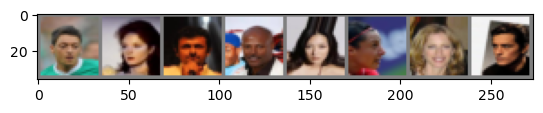

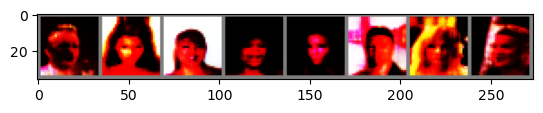

In [27]:
imshow(torchvision.utils.make_grid(real_Ce[:8]))
imshow(torchvision.utils.make_grid(fake_CE[:8]))

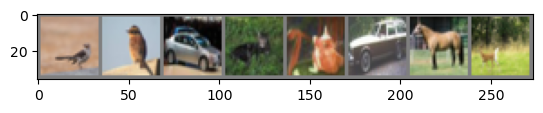

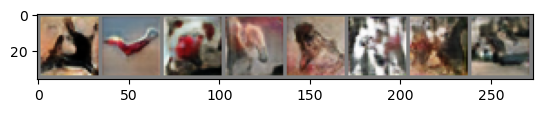

In [28]:
imshow(torchvision.utils.make_grid(real_C[:8]))
imshow(torchvision.utils.make_grid(fake_C[:8]))

In [29]:
print("Calculating Inception Score for CelebA dataset: ")
means_Ce, std_Ce  = inception_score(real_Ce, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_Ce, means_Ce)
means_fake, std_fake = inception_score(fake_CE, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_fake, means_fake)

Calculating Inception Score for CelebA dataset: 


c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\LastTerm\Progressive_Growing_of_GAN\ProgressiveGAN\utils.py:123: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


0.16632650379960656 1.480500409363527
0.14648145982341124 1.574372192456473


In [30]:
print("Calculating Inception Score for CelebA dataset: ")
fid_score(means_Ce, means_fake, std_Ce, std_fake)

Calculating Inception Score for CelebA dataset: 


2.1617708673255067

In [31]:
print("Calculating Inception Score for CIFAR10 dataset: ")
means_C, std_C  = inception_score(real_C, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_Ce, means_Ce)
means_fake, std_fake  = inception_score(fake_C, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_fake, means_fake)

Calculating Inception Score for CIFAR10 dataset: 
0.16632650379960656 1.480500409363527
0.11426247464978156 1.496050711989595


In [32]:
fid_score(means_C, means_fake, std_C, std_fake)

2.2635625424771955

In [33]:

import torchvision.models as models

critic = models.resnet18(pretrained=True)
critic.fc = torch.nn.Linear(512, 1)
critic.to(config.DEVICE)
opt_critic = optim.Adam(dis.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
load_checkpoint('D:../../weightCelebA/critic.pth', dis, opt_critic, config.LEARNING_RATE)
critic.eval()

c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> Loading checkpoint


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
from sklearn.metrics import precision_score, recall_score

critic.to(config.DEVICE)

real_labels = torch.ones(64, dtype=torch.float32, device=config.DEVICE)
fake_labels = torch.zeros(64, dtype=torch.float32, device=config.DEVICE)


def Precision_Recall(real_loader, fake_loader, device):
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for images, _ in real_loader:
            images = images.to(device)
            outputs = critic(images).flatten()
            scores = torch.sigmoid(outputs).cpu().numpy().tolist()
            all_labels += [1] * len(scores)
            all_scores += scores

        for images, _ in fake_loader:
            images = images.to(device)
            outputs = critic(images).flatten()
            scores = torch.sigmoid(outputs).cpu().numpy().tolist()
            all_labels += [0] * len(scores)
            all_scores += scores

    precision = precision_score(all_labels, np.round(all_scores))
    recall = recall_score(all_labels, np.round(all_scores))
    return precision, recall


In [44]:
PC, RC = Precision_Recall(real_loader_C, fake_loader_C, device= config.DEVICE)
PCE, RCE = Precision_Recall(real_loader_CE, fake_loader_CE, device= config.DEVICE)

In [45]:
print(PC, RC)
print(PCE, RCE)

0.9951041928194828 0.15854
0.998459296970509 0.5885616414691089
